In [3]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if "GPU" not in device_name:
    print("GPU device not found")
else:
    print(f'Found GPU at: {device_name}')

# Alternative way to check
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")


Found GPU at: /device:GPU:0
GPU available (YESS!!!!)


In [5]:
!pip install tensorflow-addons

In [6]:
!pip install transformers


In [7]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("l3cube-pune/tamil-bert")
model = AutoModelForMaskedLM.from_pretrained("l3cube-pune/tamil-bert")

# Sample Tamil sentence with a [MASK] token to predict
sentence = "தமிழ்நாட்டின் தலைநகரம் [MASK] ஆகும்."

# Tokenize the sentence
inputs = tokenizer(sentence, return_tensors="pt")

# Get model predictions
with torch.no_grad():
    outputs = model(**inputs)
    predictions = outputs.logits

# Get the predicted token for [MASK]
masked_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
predicted_token_id = torch.argmax(predictions[0, masked_index, :], dim=-1)

# Decode the predicted token
predicted_token = tokenizer.decode(predicted_token_id)
print(f"Predicted word for [MASK]: {predicted_token}")


tokenizer_config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/6.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/951M [00:00<?, ?B/s]

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


Predicted word for [MASK]: சென்னை


# **PART 2**

In [8]:
!!pip install datasets

['Requirement already satisfied: datasets in /opt/conda/lib/python3.10/site-packages (3.0.1)',
 'Requirement already satisfied: filelock in /opt/conda/lib/python3.10/site-packages (from datasets) (3.15.1)',
 'Requirement already satisfied: numpy>=1.17 in /opt/conda/lib/python3.10/site-packages (from datasets) (1.26.4)',
 'Requirement already satisfied: pyarrow>=15.0.0 in /opt/conda/lib/python3.10/site-packages (from datasets) (16.1.0)',
 'Requirement already satisfied: dill<0.3.9,>=0.3.0 in /opt/conda/lib/python3.10/site-packages (from datasets) (0.3.8)',
 'Requirement already satisfied: pandas in /opt/conda/lib/python3.10/site-packages (from datasets) (2.2.2)',
 'Requirement already satisfied: requests>=2.32.2 in /opt/conda/lib/python3.10/site-packages (from datasets) (2.32.3)',
 'Requirement already satisfied: tqdm>=4.66.3 in /opt/conda/lib/python3.10/site-packages (from datasets) (4.66.4)',
 'Requirement already satisfied: xxhash in /opt/conda/lib/python3.10/site-packages (from data

In [9]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
import numpy as np
from sklearn.metrics import classification_report
import torch

# Load dataset
ds = load_dataset("unimelb-nlp/wikiann", "ta")

# Initialize tokenizer and model for Tamil BERT
model_name = "l3cube-pune/tamil-bert"
tokenizer = AutoTokenizer.from_pretrained(model_name)


README.md:   0%|          | 0.00/158k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/92.4k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/92.7k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/15000 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
# Preprocessing the dataset to align NER tags with tokens
label_list = ["O", "B-PER", "I-PER", "B-ORG", "I-ORG", "B-LOC", "I-LOC"]

def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    previous_word_id = None
    for word_id in word_ids:
        if word_id is None:
            new_labels.append(-100)  # Ignore these tokens in the loss
        elif word_id != previous_word_id:
            new_labels.append(labels[word_id])  # Only label first token of the word
        else:
            # Continue with I- tags for inner tokens, otherwise ignore
            new_labels.append(labels[word_id] if label_list[labels[word_id]].startswith("I-") else -100)
        previous_word_id = word_id
    return new_labels

def preprocess_data(batch):
    tokenized_inputs = tokenizer(batch["tokens"], truncation=True, is_split_into_words=True, padding="max_length", max_length=128)
    all_word_ids = [tokenized_inputs.word_ids(i) for i in range(len(batch["tokens"]))]

    # Align labels with word ids for each example in the batch
    all_aligned_labels = [
        align_labels_with_tokens(labels, word_ids) for labels, word_ids in zip(batch["ner_tags"], all_word_ids)
    ]

    # Add aligned labels to tokenized inputs
    tokenized_inputs["labels"] = all_aligned_labels
    return tokenized_inputs


In [12]:
# Apply preprocessing to dataset
tokenized_ds = ds.map(preprocess_data, batched=True)

# Set format for PyTorch
tokenized_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

In [13]:

# Load the Tamil BERT model for token classification
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(label_list))

# Data collator for padding and batch processing
data_collator = DataCollatorForTokenClassification(tokenizer)

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none"
    # wandb disable
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at l3cube-pune/tamil-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [14]:
# Train the model
trainer.train()

# Evaluate the model
predictions, labels, _ = trainer.predict(tokenized_ds["test"])
predictions = np.argmax(predictions, axis=2)

Epoch,Training Loss,Validation Loss
1,1.631100,1.060084
2,0.917200,0.719960
3,0.676300,0.640382


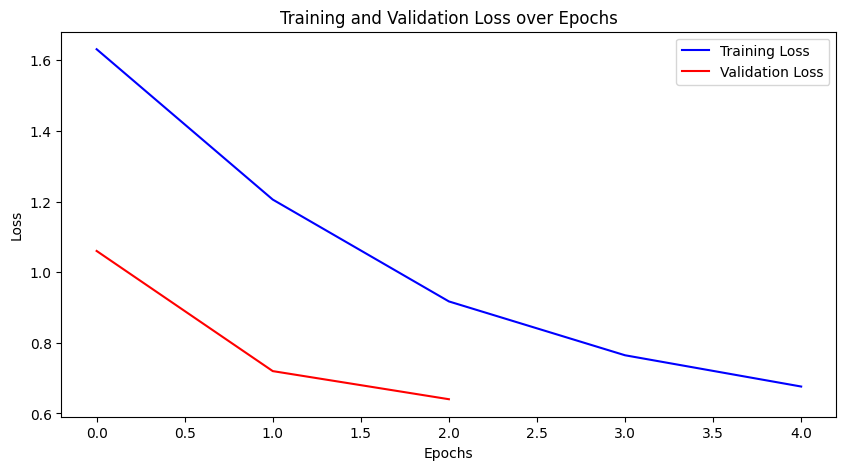

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming trainer.state.log_history contains the logged metrics
log_history = trainer.state.log_history

# Extract loss and accuracy from log history
train_loss = [log["loss"] for log in log_history if "loss" in log]
eval_loss = [log["eval_loss"] for log in log_history if "eval_loss" in log]
accuracy = [log["eval_accuracy"] for log in log_history if "eval_accuracy" in log]

# Plotting Loss
plt.figure(figsize=(10,5))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(eval_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()




In [27]:
def test_model(sentences):
    # Set the model to evaluation mode
    model.eval()
    
    for sentence in sentences:
        # Tokenize the input sentence
        tokenized_input = tokenizer(sentence, truncation=True, padding="max_length", max_length=128, return_tensors="pt")
        
        # Move input tensors to the appropriate device (CPU or GPU)
        input_ids = tokenized_input["input_ids"].to(model.device)  # Ensure input is on the correct device
        attention_mask = tokenized_input["attention_mask"].to(model.device)

        # Make predictions using the model
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
        
        # Get predictions and convert logits to labels
        predictions = np.argmax(outputs.logits.cpu().numpy(), axis=2)  # Move logits to CPU if necessary

        # Align tokens with predictions
        tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())  # Ensure tokens are on CPU
        predicted_labels = [label_list[p] for p in predictions[0]]

        # Print the results
        print(f"\nTesting sentence: {sentence}")
        for token, label in zip(tokens, predicted_labels):
            if token not in tokenizer.special_tokens_map.values() and token.strip():  # Skip special tokens and empty tokens
                print(f"Word: '{token}', Predicted Label: {label}")

# Example sentences for testing
test_sentences = [
    "என் பெயர் வின்ஸ்டன் சர்ச்சில் மற்றும் நான் கோயம்புத்தூரில் வருகிறேன்.",
    "இது ஒரு புதிய தொழில்நுட்ப மேம்பாடு.",
    "தமிழ் மொழி தமிழ்நாட்டின் நிலையான மொழியாகும்.",
    "இத்தாவரம் சீனா, இந்தியா, ஜப்பான், பப்பாசியா, மைக்குரோனீசியா போன்ற நாடுகளில் காணப்படுகிறது.",
    "சைஃப் அலி கான், தீபிகா படுகோண், ஜான் ஆபிரகாம் (நடிகர்), ஜாக்குலின் பெர்னாண்டஸ், அனில் கபூர், அமீஷா பட்டேல், மற்றும் ரஜினிகாந்த் ஆகியோர்."
]

# Test the model
test_model(test_sentences)



Testing sentence: என் பெயர் வின்ஸ்டன் சர்ச்சில் மற்றும் நான் கோயம்புத்தூரில் வருகிறேன்.
Word: 'என்', Predicted Label: O
Word: 'பெயர்', Predicted Label: O
Word: 'வின்', Predicted Label: B-PER
Word: '##ஸ்டன்', Predicted Label: I-PER
Word: 'சர்ச்', Predicted Label: I-PER
Word: '##சில்', Predicted Label: I-PER
Word: 'மற்றும்', Predicted Label: O
Word: 'நான்', Predicted Label: O
Word: 'கோ', Predicted Label: B-LOC
Word: '##யம்', Predicted Label: B-LOC
Word: '##புத்', Predicted Label: I-LOC
Word: '##தூரில்', Predicted Label: I-LOC
Word: 'வருகிறேன்', Predicted Label: O
Word: '.', Predicted Label: O

Testing sentence: இது ஒரு புதிய தொழில்நுட்ப மேம்பாடு.
Word: 'இது', Predicted Label: O
Word: 'ஒரு', Predicted Label: O
Word: 'புதிய', Predicted Label: O
Word: 'தொழில்நுட்ப', Predicted Label: B-ORG
Word: 'மேம்பாடு', Predicted Label: I-ORG
Word: '.', Predicted Label: O

Testing sentence: தமிழ் மொழி தமிழ்நாட்டின் நிலையான மொழியாகும்.
Word: 'தமிழ்', Predicted Label: B-ORG
Word: 'மொழி', Predicted Label: 

In [35]:
# Specify the directory to save the model
model_save_path = "./my_tamil_ner_model"  # Change this to your preferred path

# Save the model
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model saved to {model_save_path}")


Model saved to ./my_tamil_ner_model


In [36]:
import shutil

# Create a zip file of the model directory
shutil.make_archive(model_save_path, 'zip', model_save_path)


'/kaggle/working/my_tamil_ner_model.zip'